# **Library and Configurations**

In [ ]:
import sys
sys.path.append("..")

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error

import joblib
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import src.features as features
from src.config import config

import importlib
def r(module=features):
    importlib.reload(module)

r()

# **Load Datasets**

In [129]:
print("Loading data...")
train = pd.read_csv(config.paths.clean / "train_v2.csv")
test = pd.read_csv(config.paths.clean / "test.csv")

external_df = pd.read_csv(config.paths.clean/ "external_features.csv")
train.sort_values(["date", "location"], inplace=True)

print("\nInitial train shape:", train.shape)
print("Initial test shape :", test.shape)

Loading data...

Initial train shape: (416942, 11)
Initial test shape : (22748, 11)


In [130]:
def audit_time_gaps(
    df,
    location_col="location",
    date_col="date",
    min_gap_days=2,
    show_examples=5
):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([location_col, date_col])

    results = []

    for loc, g in df.groupby(location_col):
        g = g.sort_values(date_col)
        gaps = g[date_col].diff().dt.days

        gap_rows = g.loc[gaps >= min_gap_days, date_col]
        gap_sizes = gaps[gaps >= min_gap_days]

        results.append({
            "location": loc,
            "num_gaps": int((gaps >= min_gap_days).sum()),
            "max_gap_days": int(gap_sizes.max()) if not gap_sizes.empty else 0,
            "examples": [
                f"{prev.date()} → {curr.date()} ({int(g)} days)"
                for prev, curr, g in zip(
                    g[date_col].shift(1)[gap_sizes.index],
                    g[date_col][gap_sizes.index],
                    gap_sizes
                )
            ][:show_examples]
        })

    return pd.DataFrame(results)

gap_report = audit_time_gaps(
    train,
    location_col="location",
    date_col="date",
    min_gap_days=2
)

gap_report.sort_values("num_gaps", ascending=False)[gap_report["num_gaps"] != 0]

,location,num_gaps,max_gap_days,examples
4,Buona_Vista,1,32,[2012-12-31 → 2013-02-01 (32 days)]
27,Pulau_Ubin,1,121,[2013-10-31 → 2014-03-01 (121 days)]
18,Mandai,1,732,[2011-01-31 → 2013-02-01 (732 days)]
12,Jurong_West,1,185,[2014-06-30 → 2015-01-01 (185 days)]
20,Marine_Parade,1,93,[2013-10-31 → 2014-02-01 (93 days)]
32,Sentosa_Island,1,32,[2016-11-30 → 2017-01-01 (32 days)]


In [132]:
def fill_missing_dates_per_location(
    df,
    location_col="location",
    date_col="date"
):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    all_parts = []

    for loc, g in df.groupby(location_col):
        g = g.sort_values(date_col)

        full_range = pd.date_range(
            start=g[date_col].min(),
            end=g[date_col].max(),
            freq="D"
        )

        g_full = (
            g.set_index(date_col)
             .reindex(full_range)
             .reset_index()
             .rename(columns={"index": date_col})
        )

        g_full[location_col] = loc
        all_parts.append(g_full)

    return pd.concat(all_parts, ignore_index=True)

train_filled = fill_missing_dates_per_location(
    train,
    location_col="location",
    date_col="date"
)

In [133]:
gap_report = audit_time_gaps(
    train_filled,
    location_col="location",
    date_col="date",
    min_gap_days=2
)

gap_report.sort_values("num_gaps", ascending=False)[gap_report["num_gaps"] != 0]

,location,num_gaps,max_gap_days,examples


In [6]:
# def split_train_test(df, test_start='2024-01-01'):
#     dfc = df.copy()
#     dfc.set_index("date", inplace=True)

#     dfc.index = pd.to_datetime(dfc.index)
#     test_start = pd.to_datetime(test_start)

#     train_df = dfc[dfc.index < test_start]
#     test_df = dfc[dfc.index >= test_start]

#     print(f"Train set: {train_df.shape[0]} rows, from {train_df.index.min().date()} to {train_df.index.max().date()}")
#     print(f"Test set : {test_df.shape[0]} rows, from {test_df.index.min().date()} to {test_df.index.max().date()}")

#     train_df.reset_index(inplace=True)
#     test_df.reset_index(inplace=True)

#     train_df["date"] = pd.to_datetime(train_df["date"]).dt.strftime("%Y-%m-%d")
#     test_df["date"] = pd.to_datetime(test_df["date"]).dt.strftime("%Y-%m-%d")

#     return train_df, test_df

# train_lag, test_lag = split_train_test(combined_nbr)
# train_lag["date"] = train_lag["date"].astype("object")

In [134]:
def check_existing(df, location, date):
    df = df.copy()
    df["date"] = df["date"].astype("object")
    return df[
        (df["location"] == location) &
        (df["date"] == date)
    ]

In [135]:
core_features = [
    'mean_temperature_c', 'maximum_temperature_c', 'minimum_temperature_c',
    'mean_wind_speed_kmh', 'max_wind_speed_kmh',
]

event_features = [
    'highest_30_min_rainfall_mm', 'highest_60_min_rainfall_mm',
    'highest_120_min_rainfall_mm',
]

all_features = event_features + core_features
init_cols = train.columns

target = "daily_rainfall_total_mm"

def remove_no_signal(df, features):
    dfc = df.copy()

    mask_all_nan = dfc[features].isna().all(axis=1)
    dfc = dfc.loc[~mask_all_nan].reset_index(drop=True)

    return dfc

train_valid = remove_no_signal(train, all_features + [target])
train_valid[event_features] = train_valid[event_features].fillna(0.0)

print("No signal dropped! train valid shape:", train_valid.shape)

No signal dropped! train valid shape: (410075, 11)


# **Make Lags**

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin

class NeighborTargetLagFeatures(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        neighbors: dict,
        target: str,
        lags,
        date_col="date",
        loc_col="location",
        prefix="nbr_target"
    ):
        self.neighbors = neighbors
        self.target = target
        self.lags = sorted(lags)
        self.date_col = date_col
        self.loc_col = loc_col
        self.prefix = prefix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df[self.date_col] = pd.to_datetime(df[self.date_col])

        # set index biar alignment aman
        df.set_index([self.date_col, self.loc_col], inplace=True)

        piv = (
            df[self.target]
            .unstack(self.loc_col)
            .sort_index()
        )

        nbr = {}
        for loc, neighs in self.neighbors.items():
            if neighs:
                nbr[loc] = piv[neighs].mean(axis=1)

        nbr_df = pd.DataFrame(nbr)

        for lag in self.lags:
            col = f"{self.prefix}_mean_lag{lag}"

            df[col] = (
                nbr_df
                .shift(lag)
                .stack()
                .reindex(df.index)
                .values
            )

        df.reset_index(inplace=True)
        return df

def build_neighbors_from_corr(train, date_col="date", loc_col="location",
                              value_col="daily_rainfall_total_mm", k=5, min_corr=0.0):
    piv = train.pivot_table(index=date_col, columns=loc_col, values=value_col)
    corr = piv.corr()

    neighbors = {}
    for loc in corr.columns:
        s = corr[loc].drop(index=loc).dropna()
        s = s[s > min_corr]
        neighbors[loc] = s.sort_values(ascending=False).head(k).index.tolist()

    return neighbors

target_lags = [1, 2, 3, 7, 14, 28, 60, 91]
lag_rolling = features.LagRollingFeatures(
    specs=[
        ("highest_30_min_rainfall_mm", [1, 2, 3, 7, 14]),
        ("highest_60_min_rainfall_mm", [1, 2, 3, 7, 14]),
        ("highest_120_min_rainfall_mm", [1, 2, 3, 7, 14]),
        ("mean_temperature_c",  [1, 2, 3, 7, 14]),
        ("mean_wind_speed_kmh", [1, 2, 3, 7, 14]),
        (target, target_lags)
    ],
    target_col=target,
    group_col="location",
    date_col="date",
    rolling_funcs=["mean"],
    fill_method=None
)

neighbors = build_neighbors_from_corr(
    train,
    value_col=target,
    k=3,
    min_corr=0.61
)

nbr_lag = NeighborTargetLagFeatures(
    neighbors=neighbors,
    target=target,
    lags=target_lags
)

train_valid.sort_values(["location", "date"], inplace=True)

train_lag = lag_rolling.fit_transform(train_valid)
train_lag.reset_index(drop=True, inplace=True)

train_lag = nbr_lag.fit_transform(train_lag)

print("Combined lag shape:", train_lag.shape)

Combined lag shape: (410075, 86)


In [140]:
def filter_train(df, year, handle_nan_target="drop"):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    train_effective = df[df["date"].dt.year > year]
    train_effective["date"] = train_effective["date"].astype("object")

    if handle_nan_target == "drop":
        train_effective.dropna(subset=[target], inplace=True)
    elif handle_nan_target == "impute":
        train_effective[target].fillna(0.0, inplace=True)
    else:
        pass

    return train_effective

year = 2009
train_filtered = filter_train(train_lag, year, "impute")
print(f"Train effective shape from {year}:", train_filtered.shape)

Train effective shape from 2009: (216075, 86)


In [212]:
def split_train_val_per_location(
    df,
    location_col="location",
    date_col="date",
    target_col=target,
    val_months=18,
):
    train_parts = []
    val_parts = []

    for loc, g in df.groupby(location_col):
        g = g.sort_values(date_col)

        max_date = g[date_col].max()
        cutoff_date = max_date - pd.DateOffset(months=val_months)

        train_g = g[g[date_col] <= cutoff_date]
        val_g   = g[g[date_col] > cutoff_date]

        train_parts.append(train_g)
        val_parts.append(val_g)

    train_df = pd.concat(train_parts).reset_index(drop=True)
    val_df   = pd.concat(val_parts).reset_index(drop=True)

    return train_df, val_df

train_filtered = filter_train(train_valid, 2015, "impute")

train_effective = train_filtered.copy()

train_effective["date"] = pd.to_datetime(train_effective["date"])
train_lag["date"]       = pd.to_datetime(train_lag["date"])

train_df, val_df = split_train_val_per_location(
    train_filtered,
    location_col="location",
    date_col="date",
    target_col=target,
    val_months=24
)

X_train = train_df.drop(columns=[target])
y_train = train_df[target].fillna(0)

X_val = val_df.drop(columns=[target])
y_val = val_df[target].fillna(0)

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)

print("\nTo simulate data test, we reset validation features")
val_df = val_df[["date", "location"] + event_features + core_features]
val_df[target] = np.nan

print("Test-ish validation shape:", val_df.shape)

Train shape: (93134, 11)
Val shape  : (31870, 11)

To simulate data test, we reset validation features
Test-ish validation shape: (31870, 11)


# **Build Model**

In [144]:
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore",
                              sparse_output=False
                              ), ['location']),
        ("num", "passthrough",
            config.features.rain_extreme_columns +
            config.features.meteorogical_columns),
    ], remainder="passthrough"
).set_output(transform='pandas')

def build_pipeline(external_df: pd.DataFrame, model, transform=True):
    if transform:
        model= TransformedTargetRegressor(
            regressor=model,
            func=np.log1p,
            inverse_func=np.expm1
        )

    return Pipeline(steps=[
        # ("external_features", features.AddExternalFeatures(external_df)),
        ("structural_imputer", features.StructuralWeatherImputer(
            columns=all_features
        )),
        ("time", features.TimeFeatures()),
        ("target_encoding", features.LocationMonthTargetEncoder()),
        ("temp", features.TemperatureFeatures()),
        ("wind_rain", features.WindRainFeatures()),
        ("rolling", features.RollingStatsFeatures()),
        ("cyclical", features.CyclicalInteractionFeatures()),
        ("drop", features.DropFeatures(['date'])),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

reg_lgbm_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",

    "random_state": 42,
    "n_jobs": -1,

    "num_leaves": 15,
    "max_depth": 5,

    "min_data_in_leaf": 40,
    "min_sum_hessian_in_leaf": 8,
    "min_gain_to_split": 0.0,

    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.7,
    "feature_fraction_bynode": 0.8,

    "lambda_l2": 5.0,
    "lambda_l1": 0.0,

    "learning_rate": 0.05,
    "n_estimators": 3000,

    "verbose": -1
}

reg_xgb_params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "n_jobs": -1,

    "tree_method": "hist",
    "max_depth": 5,
    "min_child_weight": 8,
    "gamma": 0.0,

    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "colsample_bynode": 0.8,

    "reg_lambda": 5.0,
    "reg_alpha": 0.0,

    "learning_rate": 0.03,
    "n_estimators": 4000,
}

clf_params = {
    "objective":"binary:logistic",
    "eval_metric":"logloss",

    "max_depth":4,
    "min_child_weight":5,
    "gamma":0.5,

    "subsample":0.8,
    "colsample_bytree":0.8,
    "colsample_bynode":0.8,

    "n_estimators":400,
    "learning_rate":0.05,

    "reg_alpha":0.5,
    "reg_lambda":1.5,

    "scale_pos_weight":None,

    "tree_method":"hist",
    "random_state":42,
}

reg_xgb = XGBRegressor(**reg_xgb_params)
reg_lgbm = LGBMRegressor(**reg_lgbm_params)

reg_xgb_pipeline = build_pipeline(external_df, reg_xgb, transform=True)
reg_lgbm_pipeline = build_pipeline(external_df, reg_lgbm, transform=True)

clf = XGBClassifier(**clf_params)
clf_pipeline = build_pipeline(external_df, clf, transform=False)

In [191]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def make_time_folds(df, date_col, n_folds=3, val_years=2):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    years = sorted(df[date_col].dt.year.unique())

    folds = []
    for i in range(n_folds):
        val_start_year = years[-(n_folds - i) * val_years]
        val_end_year   = val_start_year + val_years - 1

        train_idx = df[df[date_col].dt.year < val_start_year].index
        val_idx   = df[
            (df[date_col].dt.year >= val_start_year) &
            (df[date_col].dt.year <= val_end_year)
        ].index

        folds.append((train_idx, val_idx))

    return folds

def objective(trial):

    params = {
        "model__regressor__max_depth": trial.suggest_int("max_depth", 3, 8),
        "model__regressor__min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "model__regressor__gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "model__regressor__subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "model__regressor__colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "model__regressor__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "model__regressor__n_estimators": trial.suggest_int("n_estimators", 500, 4000),
        "model__regressor__reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "model__regressor__reg_lambda": trial.suggest_float("reg_lambda", 1.0, 10.0),
    }

    rmses = []

    folds = make_time_folds(
        train_filtered,
        date_col="date",
        n_folds=3,
        val_years=1
    )

    for train_idx, val_idx in folds:
        X_tr = train_filtered.iloc[train_idx].drop(columns=[target])
        y_tr = train_filtered.iloc[train_idx][target]

        X_va = train_filtered.iloc[val_idx].drop(columns=[target])
        y_va = train_filtered.iloc[val_idx][target]

        model = clone(reg_xgb_pipeline)
        model.set_params(**params)

        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)
        preds = np.clip(preds, 0, None)

        rmse = root_mean_squared_error(y_va, preds)
        rmses.append(rmse)

    return np.mean(rmses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(k, v)

  0%|          | 0/50 [00:00<?, ?it/s]

[W 2026-01-22 13:48:56,422] Trial 24 failed with parameters: {'max_depth': 8, 'min_child_weight': 15, 'gamma': 0.029374178854498917, 'subsample': 0.6450872859546936, 'colsample_bytree': 0.9601363939729975, 'learning_rate': 0.0176062768326119, 'n_estimators': 2842, 'reg_alpha': 2.19174327634162, 'reg_lambda': 6.626397512620934} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_7992\2830341053.py", line 57, in objective
    model.fit(X_tr, y_tr)
    ~~~~~~~~~^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py",

KeyboardInterrupt: 

In [145]:
from sklearn.metrics import accuracy_score

y_train_clf = (y_train > 1).astype(int)
y_val_clf = (y_val > 1).astype(int)

scale_pos_weight = len(y_train_clf[y_train_clf==0]) / len(y_train_clf[y_train_clf==1])
clf_pipeline.set_params(model__scale_pos_weight=scale_pos_weight)

clf_pipeline.fit(X_train, y_train_clf)
clf_pred = clf_pipeline.predict(X_val)

print("Accuracy:", accuracy_score(y_val_clf, clf_pred))

Accuracy: 0.9832444304989018


In [146]:
from sklearn.metrics import classification_report

print(classification_report(y_val_clf, clf_pred, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.979     0.984     17311
           1      0.976     0.988     0.982     14559

    accuracy                          0.983     31870
   macro avg      0.983     0.984     0.983     31870
weighted avg      0.983     0.983     0.983     31870



In [147]:
from sklearn.metrics import average_precision_score, roc_auc_score

proba = clf_pipeline.predict_proba(X_val)[:, 1]

print("PR-AUC:", average_precision_score(y_val_clf, proba))
print("ROC-AUC:", roc_auc_score(y_val_clf, proba))

PR-AUC: 0.9986535779577344
ROC-AUC: 0.9986824112948174


In [148]:
y_train_clf = (y_train > 1).astype(int)

print("Fitting classifier...")
clf_pipeline.fit(X_train, y_train_clf)
rain_mask_train = y_train > 1

print("Fitting regressor...")
reg_xgb_pipeline.fit(
    X_train[rain_mask_train],
    y_train[rain_mask_train]
)

p_rain = clf_pipeline.predict_proba(X_val)[:, 1]
reg_pred = reg_xgb_pipeline.predict(X_val)
final_pred = p_rain * reg_pred

final_pred = np.clip(final_pred, 0, None)
rmse = root_mean_squared_error(y_val, final_pred)
print("RMSE:", rmse)

Fitting classifier...
Fitting regressor...
RMSE: 5.186480407500764


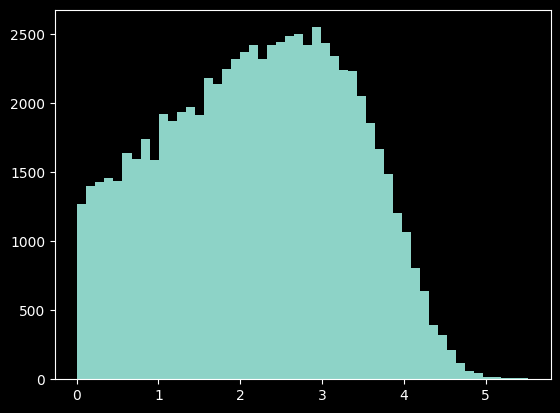

In [153]:
rain_mask_train = y_train > 1
plt.hist(np.log(y_train[rain_mask_train]), bins = 50)

plt.show()

In [94]:
%time

# fit
clf_pipeline.fit(X_train, (y_train > 1).astype(int))
reg_xgb_pipeline.fit(X_train, y_train)

# predict
p_rain = clf_pipeline.predict_proba(X_val)[:, 1]
reg_pred = reg_xgb_pipeline.predict(X_val)

final_pred = p_rain * reg_pred

rmse = root_mean_squared_error(y_val, final_pred)
print("RMSE:", rmse)

CPU times: total: 0 ns
Wall time: 23.4 μs
RMSE: 5.43272694668506


In [95]:
err = (final_pred - y_val) ** 2

df_err = pd.DataFrame({
    "y": y_val,
    "pred": final_pred,
    "sq_err": err
})

df_err.sort_values("sq_err", ascending=False).head(20)

,y,pred,sq_err
14133,194.656489,71.428772,15185.070133
21734,87.032967,208.117340,14661.425398
14862,195.419847,77.247604,13964.679006
26461,190.976298,76.336792,13142.216403
17728,157.846154,57.324444,10104.614187
24282,174.657534,75.960327,9741.138689
21713,42.558140,137.350082,8985.512432
18453,150.190901,55.546352,8957.590579
21675,79.347826,169.798599,8181.342365
18913,44.444444,133.828369,7989.485994


In [ ]:
df = train.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["doy"] = df["date"].dt.dayofyear

full = []

for (loc, year), g in df.groupby(["location", "year"]):
    cal = pd.date_range(
        f"{year}-01-01",
        f"{year}-12-31",
        freq="D"
    )

    tmp = (
        g.set_index("date")
         .reindex(cal)
         .rename_axis("date")
         .reset_index()
    )

    tmp["location"] = loc
    tmp["year"] = year
    tmp["doy"] = tmp["date"].dt.dayofyear

    full.append(tmp)

df_full = pd.concat(full, axis=0, ignore_index=True)

df_full["is_wet"] = (df_full[target] > 0).astype(int)

wet_corr_per_loc = {}

for loc, g in df_full.groupby("location"):
    pivot = g.pivot_table(
        index="doy",
        columns="year",
        values="is_wet",
        aggfunc="mean"
    )

    if pivot.shape[1] >= 2:
        wet_corr_per_loc[loc] = pivot.corr()

In [ ]:
import numpy as np
import pandas as pd


df = df_full.copy()   # hasil dari calendar-normalized sebelumnya

results = []

for loc, g in df.groupby("location"):
    # threshold extreme per lokasi
    thr = g[target].quantile(0.95)

    yearly = (
        g[g[target] >= thr]
        .groupby("year")[target]
        .agg(
            extreme_count="count",
            extreme_max="max"
        )
        .sort_index()
    )

    # butuh minimal 2 tahun
    if yearly.shape[0] < 2:
        continue

    count_corr = yearly["extreme_count"].corr(
        yearly["extreme_count"].shift(1)
    )

    max_corr = yearly["extreme_max"].corr(
        yearly["extreme_max"].shift(1)
    )

    results.append({
        "location": loc,
        "extreme_count_corr": count_corr,
        "extreme_max_corr": max_corr,
        "n_years": yearly.shape[0],
    })

extreme_corr_df = pd.DataFrame(results).sort_values(
    "extreme_count_corr",
    ascending=False
)

print(extreme_corr_df)

                  location  extreme_count_corr  extreme_max_corr  n_years
38               Toa_Payoh            0.533129         -0.142564       14
34           Somerset_Road            0.479020         -0.398412       13
29              Queenstown            0.468271          0.003080       44
23           Pasir_Panjang            0.459737          0.292637       14
16  Lower_Peirce_Reservoir            0.433679         -0.136828       14
18                  Mandai            0.395679          0.184620       42
36          Tanjong_Katong            0.388676         -0.092521       44
27              Pulau_Ubin            0.377529         -0.112872       15
42  Upper_Peirce_Reservoir            0.349424         -0.172363       14
40              Tuas_South            0.340463         -0.245389       13
33                   Simei            0.332396          0.213051       15
13              Kent_Ridge            0.324330          0.411017       15
14        Kranji_Reservoir            

# **Simulation**

In [154]:
q = (
    train_df
    .groupby("location")[target]
    .quantile([0.90, 0.95, 0.99, 0.995, 0.999, 1.0])
    .unstack()
    .rename(columns={
        0.90: "q90",
        0.95: "q95",
        0.99: "q99",
        0.995: "q995",
        0.999: "q999",
        1.0: "max"
    })
)

loc = train_df["location"].values
sample_weight = np.ones(len(y_train))

for i, (yi, li) in enumerate(zip(y_train.values, loc)):
    q90  = q.loc[li, "q90"]
    q95  = q.loc[li, "q95"]
    q99  = q.loc[li, "q99"]
    q995 = q.loc[li, "q995"]
    q999 = q.loc[li, "q999"]

    if yi > q999:
        sample_weight[i] = 11
    elif yi > q995:
        sample_weight[i] = 9
    elif yi > q99:
        sample_weight[i] = 7
    elif yi > q95:
        sample_weight[i] = 5
    elif yi > q90:
        sample_weight[i] = 3

pd.Series(sample_weight).describe(percentiles=[.5, .9, .95, .99])

count    184205.000000
mean          1.332901
std           1.129625
min           1.000000
50%           1.000000
90%           3.000000
95%           5.000000
99%           7.000000
max          11.000000
dtype: float64

In [162]:
q = (
    train_df
    .groupby("location")[target]
    .quantile([0.90, 0.95, 0.99, 0.995, 0.999, 1.0])
    .unstack()
    .rename(columns={
        0.90: "q90",
        0.95: "q95",
        0.99: "q99",
        0.995: "q995",
        0.999: "q999",
        1.0: "max"
    })
)

loc = train_df["location"].values
sample_weight = np.ones(len(y_train))

for i, (yi, li) in enumerate(zip(y_train.values, loc)):
    q90  = q.loc[li, "q90"]
    q95  = q.loc[li, "q95"]
    q99  = q.loc[li, "q99"]
    q995 = q.loc[li, "q995"]
    q999 = q.loc[li, "q999"]

    if yi > q999:
        sample_weight[i] = 11
    elif yi > q995:
        sample_weight[i] = 9
    elif yi > q99:
        sample_weight[i] = 7
    elif yi > q95:
        sample_weight[i] = 5
    elif yi > q90:
        sample_weight[i] = 3

pd.Series(sample_weight).describe(percentiles=[.5, .9, .95, .99])

count    184205.000000
mean          1.332901
std           1.129625
min           1.000000
50%           1.000000
90%           3.000000
95%           5.000000
99%           7.000000
max          11.000000
dtype: float64

In [164]:
rain_mask = y_train > 1

print("Fitting XGB Regressor Pipeline...")
reg_xgb_pipeline.fit(
    X_train[rain_mask],
    y_train[rain_mask],
    model__sample_weight=sample_weight[rain_mask]
)

print("Fitting LGBM Regressor Pipeline...")
reg_lgbm_pipeline.fit(
    X_train[rain_mask],
    y_train[rain_mask],
    model__sample_weight=sample_weight[rain_mask]
)

print("Fitting Classifier...")
clf_pipeline.fit(
    X_train,
    (rain_mask).astype(int)
)

print("Done!")

Fitting XGB Regressor Pipeline...
Fitting LGBM Regressor Pipeline...
Fitting Classifier...
Done!


In [167]:
from tqdm import tqdm

val_df["date"] = pd.to_datetime(val_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

history = (
    train_df
    .sort_values(["location", "date"])
    .groupby("location")
    .tail(max(target_lags))
    .reset_index(drop=True)
)

future = (
    val_df
    .sort_values(["location", "date"])
    .reset_index(drop=True)
)

all_preds = []

for current_date in tqdm(sorted(future["date"].unique())):
    future_day = future[future["date"] == current_date].copy()

    available_loc = future_day["location"].unique()
    temp = pd.concat([history, future_day], axis=0)

    temp_lag = lag_rolling.fit_transform(temp)
    temp_nbr = nbr_lag.fit_transform(temp_lag)

    today_lag = temp_nbr[
        (temp_nbr["date"] == current_date) &
        (temp_nbr["location"].isin(available_loc))
    ].sort_values("location")

    today_lag["date"] = pd.to_datetime(today_lag["date"])

    X_pred = today_lag.drop(columns=[target], errors="ignore")

    p_rain = clf_pipeline.predict_proba(X_pred)[:, 1]
    y_hat_xgb = reg_xgb_pipeline.predict(X_pred)
    y_hat_lgbm = reg_lgbm_pipeline.predict(X_pred)

    y_amt = (y_hat_xgb + y_hat_lgbm) / 2

    y_hat = p_rain * y_amt
    y_hat = np.clip(y_hat, 0, None)

    y_hat_xgb = np.clip(y_hat_xgb, 0, None) * p_rain
    y_hat_lgbm = np.clip(y_hat_lgbm, 0, None) * p_rain

    today_lag[target] = y_hat
    today_lag[f"{target}_xgb"] = y_hat_xgb
    today_lag[f"{target}_lgbm"] = y_hat_lgbm

    all_preds.append(today_lag[["location", "date",
                                target, f"{target}_xgb",
                                f"{target}_lgbm"]])

    history = pd.concat([history, today_lag[init_cols]], axis=0)
    history = (
        history
        .sort_values(["location", "date"])
        .groupby("location", group_keys=False)
        .tail(max(target_lags))
        .reset_index(drop=True)
    )

100%|██████████| 745/745 [03:13<00:00,  3.85it/s]


In [168]:
val_pred = pd.concat(all_preds, axis=0).sort_values(["location", "date"])
val_pred["y_true"] = y_val.values
meta_features = val_pred[[target, f"{target}_xgb", f"{target}_lgbm"]]

val_pred.head()

,location,date,daily_rainfall_total_mm,daily_rainfall_total_mm_xgb,daily_rainfall_total_mm_lgbm,y_true
91,Admiralty,2022-01-01,25.116905,28.386744,21.847065,16.964286
91,Admiralty,2022-01-02,37.080484,41.337608,32.823360,43.571429
91,Admiralty,2022-01-03,0.132297,0.183344,0.081250,0.892857
91,Admiralty,2022-01-04,40.059101,47.451344,32.666857,31.858407
91,Admiralty,2022-01-05,15.797523,13.629595,17.965451,11.250000


In [169]:
from sklearn.linear_model import LinearRegression

meta_linear = LinearRegression()
meta_linear.fit(meta_features.drop(columns=[target]), meta_features[target])

meta_lr = meta_linear.predict(meta_features.drop(columns=[target]))
val_pred["meta_lr"] = meta_lr

In [170]:
meta_xgb = XGBRegressor(random_state=42)
meta_xgb.fit(meta_features.drop(columns=[target]), meta_features[target])

meta_predict = meta_xgb.predict(meta_features.drop(columns=[target]))
val_pred["meta_xgb"] = meta_predict

In [171]:
y_true = y_val.values
pred_xgb = val_pred[f"{target}_xgb"].values
pred_lgbm = val_pred[f"{target}_lgbm"].values

best_rmse = np.inf
best_w = None

for w in np.linspace(0.0, 1.0, 1000):  # step 0.05
    blended = w * pred_xgb + (1 - w) * pred_lgbm
    rmse = root_mean_squared_error(y_true, blended)

    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w

print(f"Best RMSE  : {best_rmse:.5f}")
print(f"Best w_xgb : {best_w:.2f}")
print(f"Best w_lgbm: {1-best_w:.2f}")

Best RMSE  : 5.18272
Best w_xgb : 0.99
Best w_lgbm: 0.01


In [61]:
val_pred = val_pred.copy()
val_pred['y_true'] = y_val.values

pred_cols = [
    'daily_rainfall_total_mm_xgb',
    'daily_rainfall_total_mm_lgbm',
    'meta_lr',
    'meta_xgb'
]

for col in pred_cols:
    val_pred[f'err_{col}'] = val_pred[col] - val_pred['y_true']
    val_pred[f'abs_err_{col}'] = val_pred[f'err_{col}'].abs()
    val_pred[f'sq_err_{col}'] = val_pred[f'err_{col}'] ** 2

In [64]:
err_by_loc = (
    val_pred
    .groupby('location')[ [f'abs_err_{c}' for c in pred_cols] ]
    .mean()
    .sort_values(by=f'abs_err_{pred_cols[0]}', ascending=False)
)

err_by_loc

,abs_err_daily_rainfall_total_mm_xgb,abs_err_daily_rainfall_total_mm_lgbm,abs_err_meta_lr,abs_err_meta_xgb
location,,,,
Tengah,2.189233,3.377606,2.684486,2.685341
Sembawang,1.928521,3.098272,2.378550,2.396264
Seletar,1.862147,2.557751,1.750579,1.756931
Kent_Ridge,1.860014,2.780646,1.892179,1.911935
Choa_Chu_Kang_South,1.846335,3.108546,2.105698,2.150541
Clementi,1.833149,3.536505,2.458407,2.457341
Pulau_Ubin,1.828404,3.259363,2.436888,2.441067
Ulu_Pandan,1.819722,2.615581,1.798994,1.801277
Jurong_Pier,1.804838,2.529233,1.734016,1.740049


In [66]:
val_pred['rain_bin'] = pd.cut(
    val_pred['y_true'],
    bins=[-1, 0, 10, 30, 100, np.inf],
    labels=['no_rain', 'light', 'moderate', 'heavy', 'extreme']
)

err_by_rain = (
    val_pred
    .groupby('rain_bin')[ [f'abs_err_{c}' for c in pred_cols] ]
    .mean()
)

print(err_by_rain)

          abs_err_daily_rainfall_total_mm_xgb  \
rain_bin                                        
no_rain                              0.037846   
light                                0.898084   
moderate                             3.774004   
heavy                                8.232530   
extreme                             48.399076   

          abs_err_daily_rainfall_total_mm_lgbm  abs_err_meta_lr  \
rain_bin                                                          
no_rain                               0.029275         0.033533   
light                                 1.172280         0.881008   
moderate                              5.242873         3.578001   
heavy                                15.306897         9.896323   
extreme                              71.482649        59.003811   

          abs_err_meta_xgb  
rain_bin                    
no_rain           0.033658  
light             0.881939  
moderate          3.580779  
heavy             9.900791  
extreme     

In [68]:
val_pred.sort_values(
    by='abs_err_meta_xgb',
    ascending=False
).head()

,location,date,daily_rainfall_total_mm,daily_rainfall_total_mm_xgb,daily_rainfall_total_mm_lgbm,meta_lr,meta_xgb,y_true,err_daily_rainfall_total_mm_xgb,abs_err_daily_rainfall_total_mm_xgb,...,err_daily_rainfall_total_mm_lgbm,abs_err_daily_rainfall_total_mm_lgbm,sq_err_daily_rainfall_total_mm_lgbm,err_meta_lr,abs_err_meta_lr,sq_err_meta_lr,err_meta_xgb,abs_err_meta_xgb,sq_err_meta_xgb,rain_bin
1931,Marine_Parade,2023-02-28,59.087355,71.254005,46.920703,59.087373,57.635799,195.419847,-124.165842,124.165842,...,-148.499144,148.499144,22051.995910,-136.332475,136.332475,18586.543661,-137.784048,137.784048,18984.443861,extreme
1839,Marina_Barrage,2023-02-28,57.711618,75.804962,39.618274,57.711622,59.460407,194.656489,-118.851526,118.851526,...,-155.038215,155.038215,24036.848094,-136.944867,136.944867,18753.896517,-135.196081,135.196081,18277.980397,extreme
3403,Tanjong_Katong,2023-02-28,56.403869,68.060349,44.747390,56.403886,57.635799,190.976298,-122.915950,122.915950,...,-146.228908,146.228908,21382.893532,-134.572413,134.572413,18109.734234,-133.340499,133.340499,17779.688640,extreme
3127,Simei,2023-02-28,60.294801,66.343445,54.246156,60.294834,62.428871,174.657534,-108.314089,108.314089,...,-120.411378,120.411378,14498.900055,-114.362701,114.362701,13078.827319,-112.228663,112.228663,12595.272819,extreme
2299,Pasir_Ris_Central,2023-02-28,47.970486,54.611469,41.329502,47.970502,48.503704,157.846154,-103.234685,103.234685,...,-116.516652,116.516652,13576.130214,-109.875652,109.875652,12072.658811,-109.342450,109.342450,11955.771323,extreme


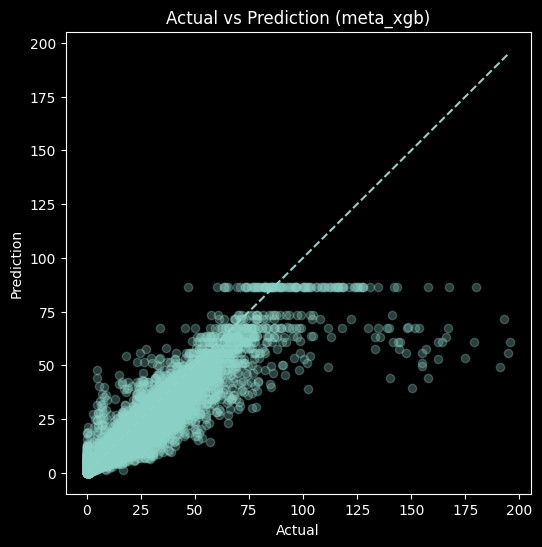

In [107]:
plt.figure(figsize=(6,6))
plt.scatter(val_pred['y_true'], val_pred['meta_xgb'], alpha=0.3)
plt.plot([0, val_pred['y_true'].max()],
         [0, val_pred['y_true'].max()],
         linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs Prediction (meta_xgb)')
plt.show()

In [176]:
print("RMSE with Ens      :", root_mean_squared_error(val_pred[target], y_val))
print("RMSE with Meta XGB :", root_mean_squared_error(val_pred["meta_xgb"], y_val))
print("RMSE with Meta lr  :", root_mean_squared_error(val_pred["meta_lr"], y_val))
print("RMSE with XGB      :", root_mean_squared_error(val_pred[f"{target}_xgb"], y_val))
print("RMSE with LGBM     :", root_mean_squared_error(val_pred[f"{target}_lgbm"], y_val))

RMSE with Ens      : 6.297970915651217
RMSE with Meta XGB : 6.301758832333994
RMSE with Meta lr  : 6.2978810389478515
RMSE with XGB      : 5.183510692886295
RMSE with LGBM     : 8.909269096506163


Text(0, 0.5, 'residual')

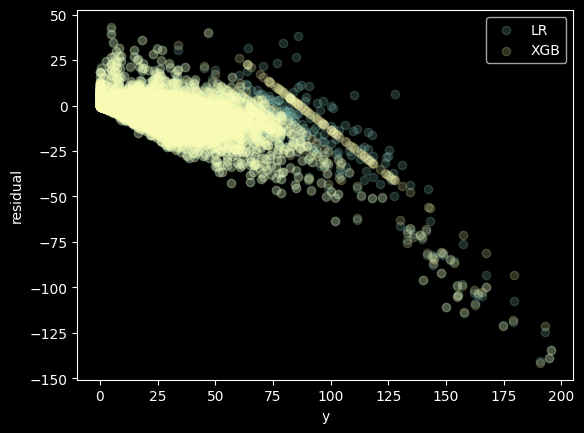

In [109]:
import matplotlib.pyplot as plt

plt.scatter(y_val, val_pred["meta_lr"].values - y_val, alpha=0.2, label="LR")
plt.scatter(y_val, val_pred["meta_xgb"].values - y_val, alpha=0.2, label="XGB")
plt.legend()
plt.xlabel("y")
plt.ylabel("residual")

In [47]:
import numpy as np
from sklearn.isotonic import IsotonicRegression

class IsotonicCalibrator:
    def __init__(self, clip_min=0.0):
        self.clip_min = clip_min
        self.model = IsotonicRegression(
            out_of_bounds="clip"
        )

    def fit(self, y_pred, y_true):
        self.model.fit(
            y_pred.astype(float),
            y_true.astype(float)
        )
        return self

    def transform(self, y_pred):
        y_corr = self.model.predict(
            y_pred.astype(float)
        )
        return np.clip(y_corr, self.clip_min, None)

# fit di OOF / validation
cal = IsotonicCalibrator()
cal.fit(
    y_pred=val_pred[target].values,
    y_true=y_val.values
)

# sanity check di validation
val_pred_corr = cal.transform(val_pred[target].values)
root_mean_squared_error(val_pred_corr, y_val)

2.8158556262747245

In [50]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

class GBDTCalibrator:
    def __init__(
        self,
        n_estimators=5000,
        learning_rate=0.2,
        max_depth=5,
        clip_min=0.0,
        random_state=42
    ):
        self.clip_min = clip_min
        self.model = GradientBoostingRegressor(
            loss="huber",
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state
        )

    def fit(self, y_pred, y_true):
        X = y_pred.reshape(-1, 1)
        self.model.fit(X, y_true)
        return self

    def transform(self, y_pred):
        X = y_pred.reshape(-1, 1)
        y_corr = self.model.predict(X)
        return np.clip(y_corr, self.clip_min, None)


cal = GBDTCalibrator()
cal.fit(
    y_pred=val_pred[target].values,
    y_true=y_val.values
)

val_pred_corr = cal.transform(val_pred[target].values)
root_mean_squared_error(val_pred_corr, y_val)

2.5877613590051056

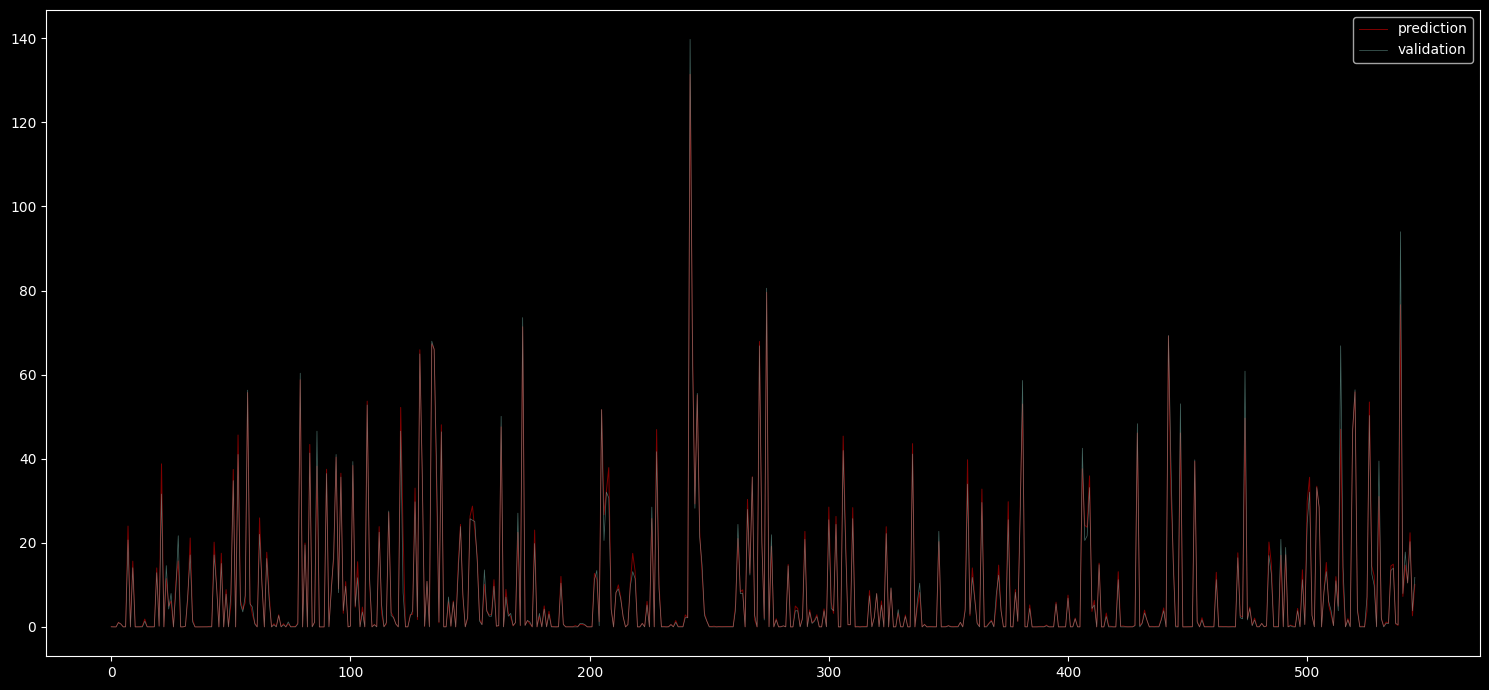

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

location = "Ang_Mo_Kio"
# val_pred["calibrated"] = val_pred_corr
plot_pred = val_pred[val_pred["location"] == location][target].reset_index(drop=True)
plot_val = y_val[val_df["location"] == location].reset_index(drop=True)

plt.figure(figsize=(15,7))

plt.plot(plot_pred, linewidth = 0.7, color="red", alpha=0.5)
plt.plot(plot_val, linewidth = 0.5, alpha=0.5)

plt.legend(["prediction", "validation"])

plt.tight_layout()
plt.show()

In [192]:
X = train_filtered.drop(columns=[target])
y = train_filtered[target]

q = (
    train_filtered
    .groupby("location")[target]
    .quantile([0.90, 0.95, 0.99, 0.995, 0.999, 1.0])
    .unstack()
    .rename(columns={
        0.90: "q90",
        0.95: "q95",
        0.99: "q99",
        0.995: "q995",
        0.999: "q999",
        1.0: "max"
    })
)

loc = train_filtered["location"].values
sample_weight = np.ones(len(y))

for i, (yi, li) in enumerate(zip(y.values, loc)):
    q90  = q.loc[li, "q90"]
    q95  = q.loc[li, "q95"]
    q99  = q.loc[li, "q99"]
    q995 = q.loc[li, "q995"]
    q999 = q.loc[li, "q999"]

    if yi > q999:
        sample_weight[i] = 11
    elif yi > q995:
        sample_weight[i] = 9
    elif yi > q99:
        sample_weight[i] = 7
    elif yi > q95:
        sample_weight[i] = 5
    elif yi > q90:
        sample_weight[i] = 3

pd.Series(sample_weight).describe(percentiles=[.5, .9, .95, .99])

count    78661.000000
mean         1.334473
std          1.135270
min          1.000000
50%          1.000000
90%          3.000000
95%          5.000000
99%          7.000000
max         11.000000
dtype: float64

In [193]:
rain_mask = y > 1

print("Fitting XGB Regressor Pipeline...")
reg_xgb_pipeline.fit(
    X[rain_mask],
    y[rain_mask],
    model__sample_weight=sample_weight[rain_mask]
)

print("Fitting LGBM Regressor Pipeline...")
reg_lgbm_pipeline.fit(
    X[rain_mask],
    y[rain_mask],
    model__sample_weight=sample_weight[rain_mask]
)

print("Fitting Classifier...")
clf_pipeline.fit(
    X,
    (rain_mask).astype(int)
)

print("Done!")

Fitting XGB Regressor Pipeline...
Fitting LGBM Regressor Pipeline...
Fitting Classifier...
Done!


In [114]:
from tqdm import tqdm

test["date"] = pd.to_datetime(test["date"])
train["date"] = pd.to_datetime(train["date"])

target = "daily_rainfall_total_mm"

history = (
    train
    .sort_values(["location", "date"])
    .groupby("location")
    .tail(max(target_lags))
    .reset_index(drop=True)
)

future = (
    test
    .sort_values(["location", "date"])
    .reset_index(drop=True)
)

all_preds = []

for current_date in tqdm(sorted(future["date"].unique())):
    future_day = future[future["date"] == current_date].copy()
    temp = pd.concat([history, future_day], axis=0)

    temp_lag = lag_rolling.fit_transform(temp)
    temp_nbr = nbr_lag.fit_transform(temp_lag)

    today_lag = (
        temp_nbr[temp_nbr["date"] == current_date]
        .sort_values("location")
    )
    today_lag["date"] = pd.to_datetime(today_lag["date"])

    X_pred = today_lag.drop(columns=[target], errors="ignore")

    p_rain = clf_pipeline.predict_proba(X_pred)[:, 1]
    y_hat_xgb = reg_xgb_pipeline.predict(X_pred)
    y_hat_lgbm = reg_lgbm_pipeline.predict(X_pred)

    y_amt = (y_hat_xgb + y_hat_lgbm) / 2

    y_hat = p_rain * y_amt
    y_hat = np.clip(y_hat, 0, None)

    y_hat = pd.Series(
        y_hat,
        index=today_lag.index
    )

    y_hat_xgb = np.clip(y_hat_xgb, 0, None) * p_rain
    y_hat_lgbm = np.clip(y_hat_lgbm, 0, None) * p_rain

    today_lag[target] = y_hat

    all_preds.append(today_lag[["location", "date", target]])

    cols_needed = ["location", "date", target] + all_features
    history = pd.concat([history, today_lag[cols_needed]], axis=0)
    history = (
        history
        .sort_values(["location", "date"])
        .groupby("location", group_keys=False)
        .tail(max(target_lags))
        .reset_index(drop=True)
    )

100%|██████████| 517/517 [02:18<00:00,  3.73it/s]


In [115]:
pred_df = (
    pd.concat(all_preds, axis=0)
    .rename(columns={target: "prediksi"})
)

if "prediksi" in test.columns:
    print("Dropping prediksi")
    test.drop(columns=["prediksi"], inplace=True)

test = test.merge(
    pred_df,
    on=["location", "date"],
    how="left"
)

test["ID (kota)"] = (
    test["location"].str.lower() + "_" +
    test["date"].dt.strftime("%Y_%m_%d")
)

test["tahun"] = test["date"].dt.year
test["bulan"] = test["date"].dt.month
test["hari"] = test["date"].dt.day

submission = test[["ID (kota)", "tahun", "bulan", "hari", "prediksi"]]
submission.to_csv(
    "yommang.csv",
    index=False
)

Dropping prediksi


# **Build Local Datasets**

In [213]:
def get_local_data(location, df=train_filtered):
    return df[df["location"] == location]

def split_features_and_target(df, target=target):
    return df.drop(columns=[target]), df[target]

local_dfs = {}
for location in train_filtered["location"].unique():
    local_df = get_local_data(location)
    local_dfs[location] = local_df

local_split = {}
for location, local_df in local_dfs.items():
    X_local, y_local = split_features_and_target(local_df)
    local_split[location] = (X_local, y_local)

# **RMSE Eval Per Location**

In [117]:
all_scores = {}

tscv = TimeSeriesSplit(5)
for location, (X, y) in local_split.items():
    scores = cross_val_score(
        reg_xgb_pipeline,
        X,
        y.fillna(0),
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    all_scores[location] = -scores

    print(f"{location} shape: {X.shape}")
    print(f"  RMSE per fold   :", [f"{x:.2f}" for x in -scores])
    print(f"  Mean RMSE       : {(-scores).mean():.2f}")
    print(f"  Noramlized RMSE : {((-scores).mean()/y.std()):.2f}")

Admiralty shape: (1805, 10)
  RMSE per fold   : ['8.64', '11.55', '5.62', '6.00', '4.76']
  Mean RMSE       : 7.32
  Noramlized RMSE : 0.51
Ang_Mo_Kio shape: (1780, 10)
  RMSE per fold   : ['11.07', '12.00', '5.23', '6.22', '3.94']
  Mean RMSE       : 7.69
  Noramlized RMSE : 0.50
Bukit_Panjang shape: (1486, 10)
  RMSE per fold   : ['9.31', '13.74', '3.85', '8.88', '3.86']
  Mean RMSE       : 7.93
  Noramlized RMSE : 0.47
Bukit_Timah shape: (1551, 10)
  RMSE per fold   : ['8.79', '8.57', '4.15', '7.47', '5.30']
  Mean RMSE       : 6.86
  Noramlized RMSE : 0.44
Buona_Vista shape: (1344, 10)
  RMSE per fold   : ['6.30', '7.62', '5.01', '7.74', '5.64']
  Mean RMSE       : 6.46
  Noramlized RMSE : 0.40
Changi shape: (1826, 10)
  RMSE per fold   : ['9.74', '15.93', '4.63', '6.78', '3.24']
  Mean RMSE       : 8.06
  Noramlized RMSE : 0.56
Choa_Chu_Kang_Central shape: (1516, 10)
  RMSE per fold   : ['8.36', '8.96', '4.93', '8.22', '3.48']
  Mean RMSE       : 6.79
  Noramlized RMSE : 0.43
Choa

# **Build Local Models**

In [297]:
import optuna
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
optuna.logging.set_verbosity(optuna.logging.WARNING)

def make_objective(
    base_pipeline,
    X,
    y,
    cv=5,
    time_series_cv=False,
    random_state=42,
):
    y = y.fillna(0)

    def objective(trial):
        params = {
            # tree structure
            "model__regressor__max_depth": trial.suggest_int("max_depth", 2, 8),
            "model__regressor__min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "model__regressor__gamma": trial.suggest_float("gamma", 0.0, 1.0),

            # learning
            "model__regressor__learning_rate": trial.suggest_float(
                "learning_rate", 0.01, 0.2, log=True
            ),
            "model__regressor__n_estimators": trial.suggest_int(
                "n_estimators", 200, 1200, step=100
            ),

            # sampling / regularization
            "model__regressor__subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "model__regressor__colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.6, 1.0
            ),
            "model__regressor__reg_alpha": trial.suggest_float(
                "reg_alpha", 1e-5, 1.0, log=True
            ),
            "model__regressor__reg_lambda": trial.suggest_float(
                "reg_lambda", 0.5, 10.0, log=True
            ),
        }

        model = clone(base_pipeline)
        model.set_params(**params)

        if time_series_cv:
            splitter = TimeSeriesSplit(n_splits=cv)
        else:
            splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)

        rmses = []
        for train_idx, val_idx in splitter.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)

            rmse = root_mean_squared_error(y_val, preds)
            rmses.append(rmse)

        return np.mean(rmses)

    return objective

local_models = {}
local_best_params = {}
local_best_scores = {}

for location, (X_local, y_local) in local_split.items():
    print(f"\nOptimizing {location}...")

    objective = make_objective(
        base_pipeline=xgb_pipeline,
        X=X_local,
        y=y_local,
        cv=5,
        time_series_cv=True,
    )

    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
    )

    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print(f"Best RMSE ({location}): {study.best_value:.5f}")

    # Train final model pakai best params
    best_model = clone(xgb_pipeline)
    best_model.set_params(
        **{f"model__regressor__{k}": v for k, v in study.best_params.items()}
    )
    best_model.fit(X_local, y_local.fillna(0))

    local_models[location] = best_model
    local_best_params[location] = study.best_params
    local_best_scores[location] = study.best_value


Optimizing Admiralty...


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2026-01-20 20:48:38,706] Trial 29 failed with parameters: {'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.4714823098873106, 'learning_rate': 0.1723018211648391, 'n_estimators': 300, 'subsample': 0.64924250536147, 'colsample_bytree': 0.6800216590664593, 'reg_alpha': 0.00042868128632643965, 'reg_lambda': 1.2156386286009824} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_4656\2382012417.py", line 59, in objective
    model.fit(X_tr, y_tr)
    ~~~~~~~~~^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py"

KeyboardInterrupt: 

In [195]:
def build_sample_weight(df, target_col=target):
    q = (
        df
        .groupby("location")[target_col]
        .quantile([0.90, 0.95, 0.99, 0.995, 0.999, 1.0])
        .unstack()
        .rename(columns={
            0.90: "q90",
            0.95: "q95",
            0.99: "q99",
            0.995: "q995",
            0.999: "q999",
            1.0: "max"
        })
    )

    y = df[target_col].values
    sample_weight = np.ones(len(y))

    q90  = np.quantile(y, 0.90)
    q95  = np.quantile(y, 0.95)
    q99  = np.quantile(y, 0.99)
    q995 = np.quantile(y, 0.995)
    q999 = np.quantile(y, 0.999)

    if yi > q999:
        sample_weight[i] = 10
    elif yi > q995:
        sample_weight[i] = 8
    elif yi > q99:
        sample_weight[i] = 6
    elif yi > q95:
        sample_weight[i] = 4
    elif yi > q90:
        sample_weight[i] = 2

    return sample_weight

In [ ]:
local_best_models = {}
local_studies = {}

for location, (X_local, y_local) in local_split.items():
    print(f"\n=== Tuning regressor for {location} ===")

    local_df = local_dfs[location]

    # ======================
    # SAMPLE WEIGHT (SERIES)
    # ======================
    w_local = pd.Series(
        build_sample_weight(local_df),
        index=local_df.index
    )

    # ======================
    # SPLIT: 2 TAHUN TERAKHIR
    # ======================
    last_date = local_df["date"].max()
    val_start = last_date - pd.DateOffset(years=1)

    train_idx_all = local_df[local_df["date"] < val_start].index
    val_idx_all   = local_df[local_df["date"] >= val_start].index

    rain_idx = y_local.index[y_local > 1]

    tr_idx = train_idx_all.intersection(rain_idx)
    va_idx = val_idx_all.intersection(rain_idx)

    def objective(trial):

        params = {
            "model__regressor__max_depth": trial.suggest_int("max_depth", 3, 5),
            "model__regressor__min_child_weight": trial.suggest_int("min_child_weight", 6, 20),
            "model__regressor__gamma": trial.suggest_float("gamma", 0.0, 1.5),
            "model__regressor__subsample": trial.suggest_float("subsample", 0.7, 0.9),
            "model__regressor__colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.85),
            "model__regressor__learning_rate": trial.suggest_float("learning_rate", 0.03, 0.08, log=True),
            "model__regressor__n_estimators": trial.suggest_int("n_estimators", 300, 1200),
            "model__regressor__reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "model__regressor__reg_lambda": trial.suggest_float("reg_lambda", 3.0, 8.0),
        }

        if len(va_idx) < 20:
            return np.inf

        model = clone(reg_xgb_pipeline)
        model.set_params(**params)

        model.fit(
            X_local.loc[tr_idx],
            y_local.loc[tr_idx].fillna(0),
            model__sample_weight=w_local.loc[tr_idx]
        )

        preds = model.predict(X_local.loc[va_idx])
        preds = np.clip(preds, 0, None)

        return root_mean_squared_error(
            y_local.loc[va_idx],
            preds
        )

    # ======================
    # RUN STUDY
    # ======================
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    # ======================
    # TRAIN FINAL MODEL
    # ======================
    best_reg = clone(reg_xgb_pipeline)
    best_reg.set_params(
        **{f"model__regressor__{k}": v for k, v in study.best_params.items()}
    )

    best_reg.fit(
        X_local.loc[rain_idx],
        y_local.loc[rain_idx].fillna(0),
        model__sample_weight=w_local.loc[rain_idx]
    )

    local_best_models[location] = {
        "regressor": best_reg,
        "classifier": local_models[location][1],
        "best_rmse": study.best_value
    }

    local_studies[location] = study


=== Tuning regressor for Admiralty ===


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2026-01-22 14:21:36,851] Trial 8 failed with parameters: {'max_depth': 4, 'min_child_weight': 16, 'gamma': 0.9708676949556301, 'subsample': 0.8052922777017062, 'colsample_bytree': 0.7286926619673386, 'learning_rate': 0.03169783152903709, 'n_estimators': 793, 'reg_alpha': 0.7816302547364502, 'reg_lambda': 7.072814756699335} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_7992\2627612557.py", line 54, in objective
    model.fit(
    ~~~~~~~~~^
        X_local.loc[tr_idx],
        ^^^^^^^^^^^^^^^^^^^^
        y_local.loc[tr_idx].fillna(0),
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        model__sample_weight=w_local.loc[tr_idx]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\ASUS\AppData\Local\Programs\Pyt

KeyboardInterrupt: 

In [125]:
from sklearn.base import clone

local_models = {}
local_weights = {}

for location, (X_local, y_local) in local_split.items():
    print(f"Training {location} model...")
    local_df = local_dfs[location]

    rain_local_mask = y_local > 1
    w_local = build_sample_weight(local_df)

    reg = clone(reg_xgb_pipeline)
    clf = clone(clf_pipeline)

    clf.fit(X_local, (rain_local_mask).astype(int))
    reg.fit(X_local[rain_local_mask],
            y_local[rain_local_mask].fillna(0),
            model__sample_weight=w_local[rain_local_mask])

    local_weights[location] = w_local
    local_models[location] = reg, clf

Training Admiralty model...
Training Ang_Mo_Kio model...
Training Bukit_Panjang model...
Training Bukit_Timah model...
Training Buona_Vista model...
Training Changi model...
Training Choa_Chu_Kang_Central model...
Training Choa_Chu_Kang_South model...
Training Clementi model...
Training East_Coast_Parkway model...
Training Jurong_Island model...
Training Jurong_Pier model...
Training Jurong_West model...
Training Kent_Ridge model...
Training Kranji_Reservoir model...
Training Lim_Chu_Kang model...
Training Lower_Peirce_Reservoir model...
Training Macritchie_Reservoir model...
Training Mandai model...
Training Marina_Barrage model...
Training Marine_Parade model...
Training Newton model...
Training Nicoll_Highway model...
Training Pasir_Panjang model...
Training Pasir_Ris_Central model...
Training Pasir_Ris_West model...
Training Paya_Lebar model...
Training Pulau_Ubin model...
Training Punggol model...
Training Queenstown model...
Training Seletar model...
Training Sembawang model...
T

In [126]:
from tqdm.auto import tqdm

predictions = []

history_df = train.copy()
history_df["date"] = pd.to_datetime(history_df["date"])
cutoff_end = pd.Timestamp("2024-01-01")
cutoff_start = cutoff_end - pd.Timedelta(days=91)

history_df = history_df[
    (history_df["date"] >= cutoff_start) &
    (history_df["date"] < cutoff_end)
]

try:
    test.set_index("date", inplace=True)
except KeyError:
    print("Index is already a date cols!")
history_df.set_index("date", inplace=True)

test.index = pd.to_datetime(test.index)
history_df.index = pd.to_datetime(history_df.index)

for date in tqdm(test.index.unique(), desc="Predicting..."):
    current_day_data = test.loc[[date]].copy()
    current_day_data[target] = np.nan

    temp_combined_df = pd.concat([history_df, current_day_data], axis=0)
    temp_combined_df.reset_index(inplace=True)

    featured_temp_df = lag_rolling.fit_transform(temp_combined_df)
    featured_temp_nbr = nbr_lag.fit_transform(featured_temp_df)
    featured_temp_nbr.set_index("date", inplace=True)

    rows_to_predict = featured_temp_nbr.loc[[date]]
    predicted_day_df = rows_to_predict.copy()

    for location in rows_to_predict["location"].unique():
        row_for_location = rows_to_predict[
            rows_to_predict["location"] == location
        ].copy()

        X = row_for_location.drop(columns=[target])
        X.reset_index(inplace=True)

        reg, clf = local_models[str(location)]

        y_rain = reg.predict(X)[0]
        p_rain = clf.predict_proba(X)[:, 1][0]

        pred = float(p_rain * y_rain)

        year = date.year
        month = date.month
        day = date.day

        predictions.append({
            "ID (kota)": f"{location.lower()}_{year}_{month:02d}_{day:02d}",
            "tahun": year,
            "bulan": month,
            "hari": day,
            "prediksi": pred,
        })

        predicted_day_df.loc[
            predicted_day_df["location"] == location, target
        ] = pred

    history_df.reset_index(inplace=True)
    history_df = pd.concat([history_df, predicted_day_df.reset_index()[cols_needed]], axis=0)
    history_df.set_index("date", inplace=True)

Index is already a date cols!


Predicting...:   0%|          | 0/517 [00:00<?, ?it/s]

In [127]:
submission = pd.DataFrame(predictions)
# submission["prediksi"] = np.clip(submission["prediksi"].values + 1, 0, None)
# submission["prediksi"] = np.where(
#     np.isclose(submission["prediksi"], 1.0, atol=1e-2),
#     0,
#     submission["prediksi"]
# )

submission.sort_values("ID (kota)", inplace=True)
filename = "submission_iterative_two_stage.csv"

print(f"Save submission to {filename} shape: {submission.shape}")
submission.to_csv(filename, index=False)

print(f"{filename} saved!")
print(submission.head())

Save submission to submission_iterative_two_stage.csv shape: (22748, 5)
submission_iterative_two_stage.csv saved!
                ID (kota)  tahun  bulan  hari   prediksi
0    admiralty_2024_01_01   2024      1     1   3.291550
44   admiralty_2024_01_02   2024      1     2   1.425383
88   admiralty_2024_01_03   2024      1     3   2.291064
132  admiralty_2024_01_04   2024      1     4  39.748257
176  admiralty_2024_01_05   2024      1     5   5.196466


In [285]:
wss = pd.read_csv(config.paths.clean/"wss.csv")
wss["date"] = pd.to_datetime(wss["date"])
wss["ID (kota)"] = (
    wss["location"].str.lower() + "_" +
    wss["date"].dt.strftime("%Y_%m_%d")
)
wss["ID (kota)"]

0         admiralty_2009_01_01
1         admiralty_2009_01_02
2         admiralty_2009_01_03
3         admiralty_2009_01_04
4         admiralty_2009_01_05
                  ...         
606089       yishun_2021_04_26
606090       yishun_2021_04_27
606091       yishun_2021_04_28
606092       yishun_2021_04_29
606093       yishun_2021_04_30
Name: ID (kota), Length: 606094, dtype: object

In [288]:
wss_gt = wss[["ID (kota)", target]].rename(
    columns={target: "gt"}
)
submission = submission.merge(
    wss_gt,
    on="ID (kota)",
    how="left"
)
submission

,ID (kota),tahun,bulan,hari,prediksi,gt_x,gt_y
0,admiralty_2024_01_01,2024,1,1,3.790257,8.5,8.5
1,admiralty_2024_01_02,2024,1,2,1.161958,0.5,0.5
2,admiralty_2024_01_03,2024,1,3,2.065356,1.5,1.5
3,admiralty_2024_01_04,2024,1,4,40.452663,67.6,67.6
4,admiralty_2024_01_05,2024,1,5,4.254688,5.4,5.4
...,...,...,...,...,...,...,...
22743,whampoa_2025_05_27,2025,5,27,-0.007838,0.0,0.0
22744,whampoa_2025_05_28,2025,5,28,-0.010888,0.0,0.0
22745,whampoa_2025_05_29,2025,5,29,4.562145,7.0,7.0
22746,whampoa_2025_05_30,2025,5,30,-0.046000,0.0,0.0


In [ ]:
joblib.dump(pipe, config.paths.models/'cv_model_v2.pkl')
print("Model saved!")